In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import logging

# Configuration du logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Liste des tickers
tickers = ["AAPL", "GOOG", "AMZN"]

# Période d'observation (5 ans)
start_date = "2013-02-28"
end_date = "2023-02-28"

# Paramètres de la fenêtre pour les séquences
window_size = 5

In [2]:
# -------------------------------
# Fonction pour télécharger les données via yfinance et calculer les indicateurs
# -------------------------------
def get_stock_data_yfinance(ticker, start, end):
    logging.info("Téléchargement des données pour %s via yfinance", ticker)
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        logging.error("Aucune donnée récupérée pour %s", ticker)
        return None
    # Assurez-vous que la colonne 'Adj Close' existe. Sinon, la créer comme copie de 'Close'
    if 'Adj Close' not in df.columns:
        df['Adj Close'] = df['Close']
    # On garde les colonnes importantes
    df = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    # Calcul des indicateurs techniques basés sur la colonne 'Close'
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['RSI'] = compute_RSI(df, period=14)
    df['MACD_hist'] = compute_MACD(df)
    df.dropna(inplace=True)
    # Création de la cible : le Close du jour suivant
    df[ticker + '_Target'] = df['Close'].shift(-1)
    df.dropna(inplace=True)
    # Renommage des colonnes pour ajouter le ticker en préfixe
    df = df.rename(columns={
        'Close': f'{ticker}_Close',
        'Adj Close': f'{ticker}_Adj_Close',
        'Volume': f'{ticker}_Volume',
        'SMA_5': f'{ticker}_SMA_5',
        'RSI': f'{ticker}_RSI',
        'MACD_hist': f'{ticker}_MACD_hist'
    })
    return df


In [3]:
# -------------------------------
# Fonctions d'indicateurs techniques (pour yfinance)
# -------------------------------
def compute_RSI(data, period=14):
    delta = data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_MACD(data, fast_period=12, slow_period=26, signal_period=9):
    ema_fast = data['Close'].ewm(span=fast_period, adjust=False).mean()
    ema_slow = data['Close'].ewm(span=slow_period, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    macd_hist = macd - signal
    return macd_hist


In [4]:
# -------------------------------
# Fusionner les données pour plusieurs tickers (via yfinance)
# -------------------------------
def merge_stock_data_yfinance(tickers, start, end):
    df_list = []
    for t in tickers:
        df = get_stock_data_yfinance(t, start, end)
        if df is not None:
            df_list.append(df)
    if not df_list:
        return None
    data_merged = df_list[0]
    for df in df_list[1:]:
        data_merged = data_merged.join(df, how='inner')
    return data_merged


In [5]:
# -------------------------------
# Création des séquences pour le modèle LSTM
# -------------------------------
def create_sequences(features, targets, window):
    X, y = [], []
    for i in range(len(features) - window):
        X.append(features[i:i+window])
        y.append(targets[i+window])
    return np.array(X), np.array(y)

In [6]:
# -------------------------------
# Préparation du dataset multi-actions
# -------------------------------
def prepare_dataset(data, tickers, window):
    feature_cols = []
    target_cols = []
    for t in tickers:
        feature_cols += [f'{t}_Close', f'{t}_Volume', f'{t}_SMA_5', f'{t}_RSI', f'{t}_MACD_hist']
        target_cols.append(f'{t}_Target')
    features = data[feature_cols].values
    targets = data[target_cols].values

    scaler_features = MinMaxScaler()
    features_scaled = scaler_features.fit_transform(features)
    scaler_targets = MinMaxScaler()
    targets_scaled = scaler_targets.fit_transform(targets)

    X, y = create_sequences(features_scaled, targets_scaled, window)
    dates = data.index[window:]
    return X, y, dates, scaler_features, scaler_targets

In [7]:
# -------------------------------
# Construction du modèle LSTM multi-sortie
# -------------------------------
def build_model(input_shape, output_dim):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, activation='tanh')))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim))
    model.compile(optimizer='adam', loss='mse')
    return model

In [8]:
# -------------------------------
# Simulation de trading multi-actions
# -------------------------------
def simulate_trading_multi(data, dates, X_test, y_pred, scaler_targets, tickers, start_index, trading_params):
    n = len(tickers)
    portfolio = []
    capitals = {t: trading_params['initial_capital_per_stock'] for t in tickers}
    positions = {t: 0 for t in tickers}
    purchase_prices = {t: None for t in tickers}
    
    for i in range(len(X_test)):
        current_idx = start_index + i + trading_params['window_size'] - 1
        current_date = dates[i]
        for idx, t in enumerate(tickers):
            col = f'{t}_Close'
            current_price = float(data[col].iloc[current_idx])
            predicted_scaled = y_pred[i][idx]
            # Inversion manuelle de l'échelle pour ce ticker
            predicted_price = (predicted_scaled - scaler_targets.min_[idx]) / scaler_targets.scale_[idx]
            
            if positions[t] == 0:
                if predicted_price > current_price * (1 + trading_params['signal_threshold']) and capitals[t] >= current_price:
                    num_shares = int(capitals[t] // current_price)
                    purchase_prices[t] = current_price
                    cost = num_shares * current_price
                    capitals[t] -= cost
                    positions[t] += num_shares
                    logging.info("%s - %s: Achat de %d actions à %.2f USD", current_date.date(), t, num_shares, current_price)
            else:
                if current_price <= purchase_prices[t] * (1 - trading_params['stop_loss_pct']):
                    revenue = positions[t] * current_price
                    capitals[t] += revenue
                    logging.info("%s - %s: Vente (Stop-Loss) de %d actions à %.2f USD", current_date.date(), t, positions[t], current_price)
                    positions[t] = 0
                    purchase_prices[t] = None
                elif current_price >= purchase_prices[t] * (1 + trading_params['take_profit_pct']):
                    revenue = positions[t] * current_price
                    capitals[t] += revenue
                    logging.info("%s - %s: Vente (Take-Profit) de %d actions à %.2f USD", current_date.date(), t, positions[t], current_price)
                    positions[t] = 0
                    purchase_prices[t] = None
                elif predicted_price < current_price * (1 - trading_params['signal_threshold']):
                    revenue = positions[t] * current_price
                    capitals[t] += revenue
                    logging.info("%s - %s: Vente (Signal baissier) de %d actions à %.2f USD", current_date.date(), t, positions[t], current_price)
                    positions[t] = 0
                    purchase_prices[t] = None
        total_value = sum(capitals[t] + positions[t] * float(data[f'{t}_Close'].iloc[current_idx]) for t in tickers)
        portfolio.append({'Date': current_date, 'Total Value': total_value})
    
    portfolio_df = pd.DataFrame(portfolio)
    portfolio_df.set_index('Date', inplace=True)
    return portfolio_df

def compute_sharpe_ratio(portfolio_df):
    portfolio_df['Daily Return'] = portfolio_df['Total Value'].pct_change()
    sharpe_ratio = np.sqrt(252) * portfolio_df['Daily Return'].mean() / portfolio_df['Daily Return'].std()
    return sharpe_ratio

def plot_portfolio(portfolio_df):
    plt.figure(figsize=(12,6))
    plt.plot(portfolio_df.index, portfolio_df['Total Value'], label='Valeur du portefeuille')
    plt.xlabel('Date')
    plt.ylabel('Valeur en USD')
    plt.title('Évolution du portefeuille multi-actions')
    plt.legend()
    plt.show()

2025-02-28 18:05:27,667 - INFO - Téléchargement des données pour AAPL via yfinance


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
2025-02-28 18:05:28,894 - INFO - Téléchargement des données pour GOOG via yfinance
[*********************100%***********************]  1 of 1 completed
2025-02-28 18:05:29,152 - INFO - Téléchargement des données pour AMZN via yfinance
[*********************100%***********************]  1 of 1 completed
2025-02-28 18:05:29,356 - INFO - Données fusionnées: 2502 lignes
2025-02-28 18:05:29,362 - INFO - Dataset préparé: X shape = (2497, 5, 15), y shape = (2497, 3)


Epoch 1/1500


/Users/polo11/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0091 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 2/1500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 3/1500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7242e-04 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 4/1500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.2443e-04 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 5/1500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6982e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 6/1500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9207e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 7/1500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.8135e-04 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 8/1500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.8828e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 9/1500
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4435e-04 - val_loss: 0.0016 

2025-02-28 18:05:56,228 - INFO - MSE Test: 83.5065
2025-02-28 18:05:56,230 - INFO - MAE Test: 7.3032
2025-02-28 18:05:56,230 - INFO - RMSE Test: 9.1382
2025-02-28 18:05:56,231 - INFO - R² Test: 0.8010


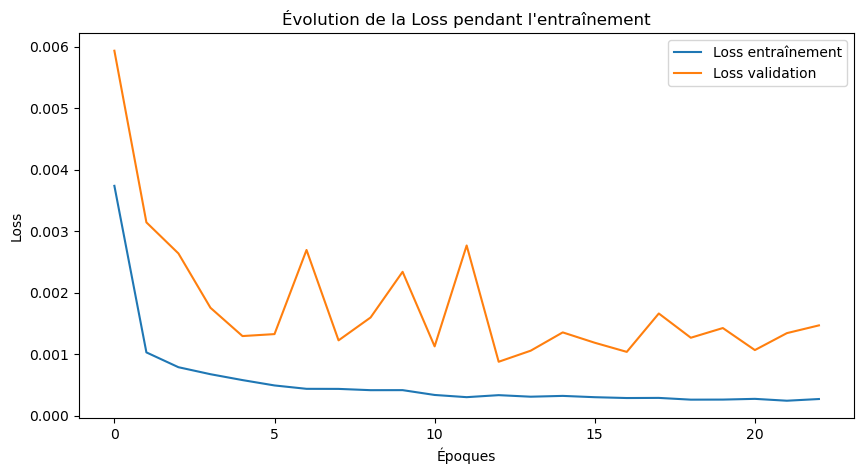

/var/folders/lj/mv9vr6rd427gvcyw4bmvq8800000gn/T/ipykernel_45611/3871217363.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data[col].iloc[current_idx])
/var/folders/lj/mv9vr6rd427gvcyw4bmvq8800000gn/T/ipykernel_45611/3871217363.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  total_value = sum(capitals[t] + positions[t] * float(data[f'{t}_Close'].iloc[current_idx]) for t in tickers)
2025-02-28 18:05:56,519 - INFO - 2021-03-09 - AAPL: Achat de 87 actions à 113.83 USD
2025-02-28 18:05:56,522 - INFO - 2021-03-10 - AAPL: Vente (Take-Profit) de 87 actions à 118.46 USD
2025-02-28 18:05:56,531 - INFO - 2021-03-19 - AAPL: Achat de 88 actions à 117.91 USD
2025-02-28 18:05:56,543 - INFO - 2021-04-05 - AAPL: Vente (Signal baissier) de 88 actions à 120.32 USD
2025-02-28 1

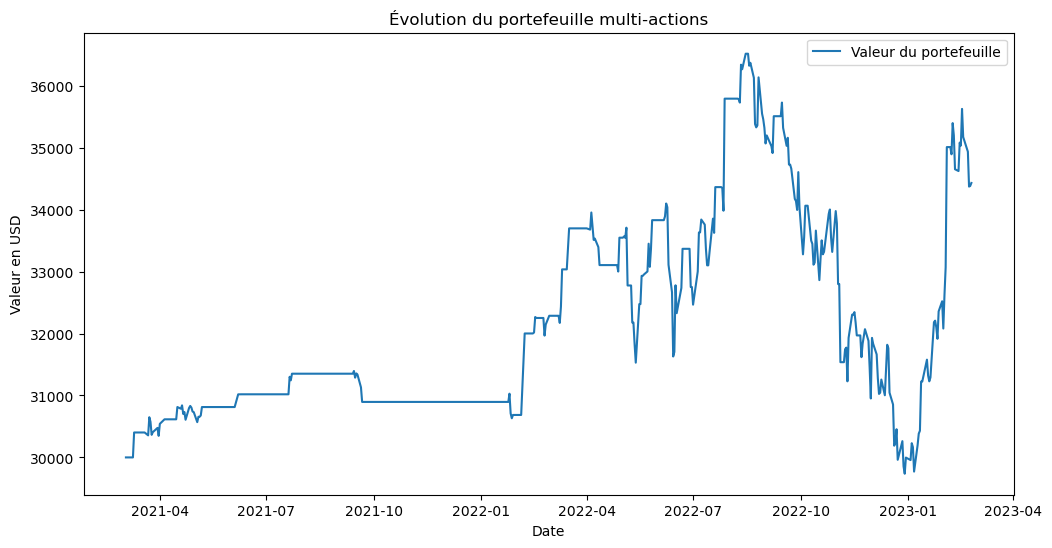

In [9]:
# -------------------------------
# Fonction principale
# -------------------------------
def main():
    # Téléchargement et fusion des données via yfinance
    data = merge_stock_data_yfinance(tickers, start_date, end_date)
    if data is None:
        logging.error("Aucune donnée récupérée.")
        return
    logging.info("Données fusionnées: %d lignes", len(data))
    
    # Préparation du dataset
    X, y, dates, scaler_features, scaler_targets = prepare_dataset(data, tickers, window_size)
    logging.info("Dataset préparé: X shape = %s, y shape = %s", X.shape, y.shape)
    
    # Séparation train/test (80 % pour entraînement)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    dates_train, dates_test = dates[:train_size], dates[train_size:]
    
    # Construction et entraînement du modèle LSTM multi-sortie
    input_shape = (window_size, X.shape[2])
    output_dim = len(tickers)  # nombre de tickers
    model = build_model(input_shape, output_dim)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
    
    history = model.fit(X_train, y_train, epochs=1500, batch_size=16, validation_split=0.1,
                        callbacks=[early_stop, reduce_lr], verbose=1)
    
    # Prédictions sur le jeu de test
    y_test_pred = model.predict(X_test)
    
    # Inversion de l'échelle pour obtenir les valeurs réelles et les prédictions
    y_test_inv = scaler_targets.inverse_transform(y_test)
    y_test_pred_inv = scaler_targets.inverse_transform(y_test_pred)
    
    mse_test = mean_squared_error(y_test_inv, y_test_pred_inv)
    mae_test = mean_absolute_error(y_test_inv, y_test_pred_inv)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test_inv, y_test_pred_inv)
    
    logging.info("MSE Test: %.4f", mse_test)
    logging.info("MAE Test: %.4f", mae_test)
    logging.info("RMSE Test: %.4f", rmse_test)
    logging.info("R² Test: %.4f", r2_test)
    
    # Tracé de l'évolution de la loss pendant l'entraînement
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Loss entraînement')
    plt.plot(history.history['val_loss'], label='Loss validation')
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Évolution de la Loss pendant l'entraînement")
    plt.show()
    
    # Simulation de trading sur le jeu de test
    trading_params = {
        'initial_capital_per_stock': 10000,
        'signal_threshold': 0.01,
        'stop_loss_pct': 0.03,
        'take_profit_pct': 0.03,
        'window_size': window_size
    }
    portfolio_df = simulate_trading_multi(data, dates_test, X_test, y_test_pred, scaler_targets, tickers, train_size, trading_params)
    final_value = portfolio_df.iloc[-1]['Total Value']
    logging.info("Valeur finale du portefeuille multi-actions: %.2f USD", final_value)
    
    sharpe = compute_sharpe_ratio(portfolio_df)
    logging.info("Sharpe Ratio: %.2f", sharpe)
    
    plot_portfolio(portfolio_df)

if __name__ == "__main__":
    main()
